# Module 1: Climate Disaster Exploratory Data Analysis

Analyzing FEMA disaster declarations from 2004-2024 to understand trends in disaster frequency, regional patterns, and seasonality.

**Data Source:** OpenFEMA API — Disaster Declarations Summaries (v2)

In [1]:
import sys
sys.path.insert(0, "..")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from src.utils.config import DATA_PROCESSED, REPORTS_FIGURES

# Ensure output directory exists
REPORTS_FIGURES.mkdir(parents=True, exist_ok=True)

sns.set_theme(style="whitegrid", palette="husl")
plt.rcParams["figure.figsize"] = (14, 6)
plt.rcParams["figure.dpi"] = 100

print("Setup complete.")

Setup complete.


## 1. Load Processed Data

In [2]:
# Load processed datasets
clean_df = pd.read_csv(
    DATA_PROCESSED / "disasters_cleaned.csv",
    parse_dates=["declarationDate", "incidentBeginDate", "incidentEndDate"],
    dtype={"fipsStateCode": str, "fipsCountyCode": str, "county_fips": str},
)
national_monthly = pd.read_csv(
    DATA_PROCESSED / "disasters_national_monthly.csv", parse_dates=["date"]
)
state_monthly = pd.read_csv(DATA_PROCESSED / "disasters_state_monthly.csv")
county_monthly = pd.read_csv(
    DATA_PROCESSED / "disasters_county_monthly.csv",
    dtype={"county_fips": str, "fipsStateCode": str},
)

print(f"Total cleaned records: {len(clean_df):,}")
print(f"Date range: {clean_df['declarationDate'].min()} to {clean_df['declarationDate'].max()}")
print(f"Unique disasters: {clean_df['disasterNumber'].nunique()}")
print(f"Unique counties: {clean_df['county_fips'].nunique()}")
print(f"States: {clean_df['state'].nunique()}")
print(f"\nDisaster categories:\n{clean_df['disaster_category'].value_counts()}")

Total cleaned records: 41,363
Date range: 2004-01-13 00:00:00+00:00 to 2024-12-24 00:00:00+00:00
Unique disasters: 2816
Unique counties: 3281
States: 57

Disaster categories:
disaster_category
Severe Storm     11867
Hurricane        11643
Other             8934
Flood             3427
Wildfire          2269
Winter Storm      2255
Coastal Storm      471
Tornado            308
Earthquake         148
Landslide           38
Volcanic             2
Drought              1
Name: count, dtype: int64


## 2. Overall Trend: Annual Disaster Counts

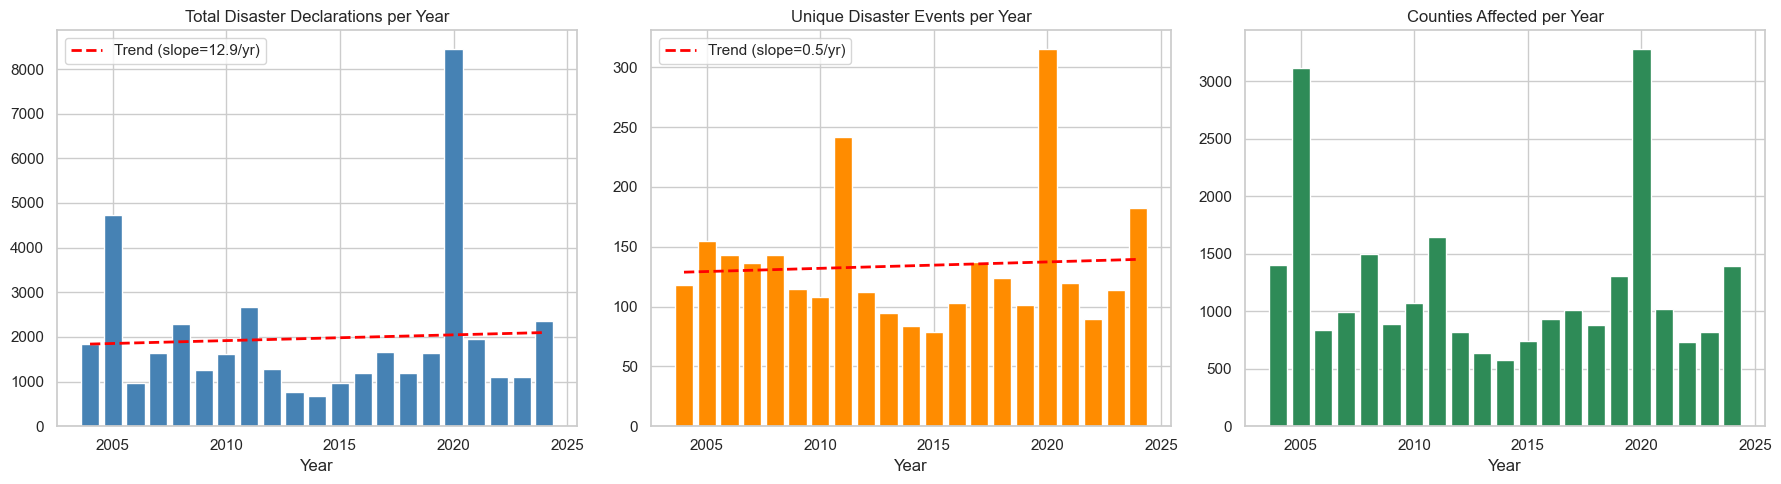


Avg annual declarations: 1970
Avg annual unique disasters: 134


In [3]:
annual = clean_df.groupby("declaration_year").agg(
    total_declarations=("disasterNumber", "count"),
    unique_disasters=("disasterNumber", "nunique"),
    counties_affected=("county_fips", "nunique"),
).reset_index()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Total declarations per year
axes[0].bar(annual["declaration_year"], annual["total_declarations"], color="steelblue")
z = np.polyfit(annual["declaration_year"], annual["total_declarations"], 1)
axes[0].plot(
    annual["declaration_year"],
    np.polyval(z, annual["declaration_year"]),
    "r--", linewidth=2, label=f"Trend (slope={z[0]:.1f}/yr)",
)
axes[0].set_title("Total Disaster Declarations per Year")
axes[0].set_xlabel("Year")
axes[0].legend()

# Unique disaster events per year
axes[1].bar(annual["declaration_year"], annual["unique_disasters"], color="darkorange")
z2 = np.polyfit(annual["declaration_year"], annual["unique_disasters"], 1)
axes[1].plot(
    annual["declaration_year"],
    np.polyval(z2, annual["declaration_year"]),
    "r--", linewidth=2, label=f"Trend (slope={z2[0]:.1f}/yr)",
)
axes[1].set_title("Unique Disaster Events per Year")
axes[1].set_xlabel("Year")
axes[1].legend()

# Counties affected per year
axes[2].bar(annual["declaration_year"], annual["counties_affected"], color="seagreen")
axes[2].set_title("Counties Affected per Year")
axes[2].set_xlabel("Year")

plt.tight_layout()
plt.savefig(REPORTS_FIGURES / "annual_disaster_trends.png", bbox_inches="tight")
plt.show()

print(f"\nAvg annual declarations: {annual['total_declarations'].mean():.0f}")
print(f"Avg annual unique disasters: {annual['unique_disasters'].mean():.0f}")

## 3. Disaster Type Breakdown Over Time

In [4]:
type_annual = (
    clean_df.groupby(["declaration_year", "disaster_category"])
    .size()
    .reset_index(name="count")
)

fig = px.area(
    type_annual,
    x="declaration_year",
    y="count",
    color="disaster_category",
    title="Disaster Declarations by Type (2004-2024)",
    labels={
        "declaration_year": "Year",
        "count": "Declarations",
        "disaster_category": "Type",
    },
)
fig.update_layout(hovermode="x unified", width=900, height=500)
fig.show()

## 4. Seasonality Analysis

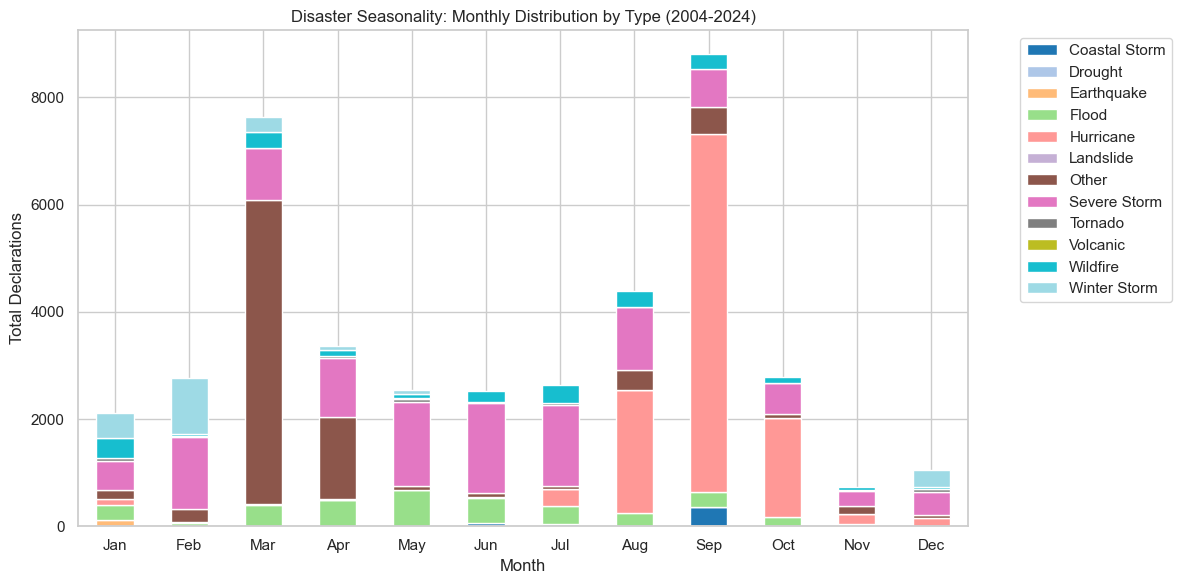

In [5]:
monthly_pattern = (
    clean_df.groupby(["declaration_month", "disaster_category"])
    .size()
    .reset_index(name="count")
)

fig, ax = plt.subplots(figsize=(12, 6))
pivot = (
    monthly_pattern.pivot(
        index="declaration_month", columns="disaster_category", values="count"
    )
    .fillna(0)
)
pivot.plot(kind="bar", stacked=True, ax=ax, colormap="tab20")
ax.set_title("Disaster Seasonality: Monthly Distribution by Type (2004-2024)")
ax.set_xlabel("Month")
ax.set_ylabel("Total Declarations")
ax.set_xticklabels(
    ["Jan", "Feb", "Mar", "Apr", "May", "Jun",
     "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"],
    rotation=0,
)
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.savefig(REPORTS_FIGURES / "seasonality_by_type.png", bbox_inches="tight")
plt.show()

## 5. State-Level Heatmap

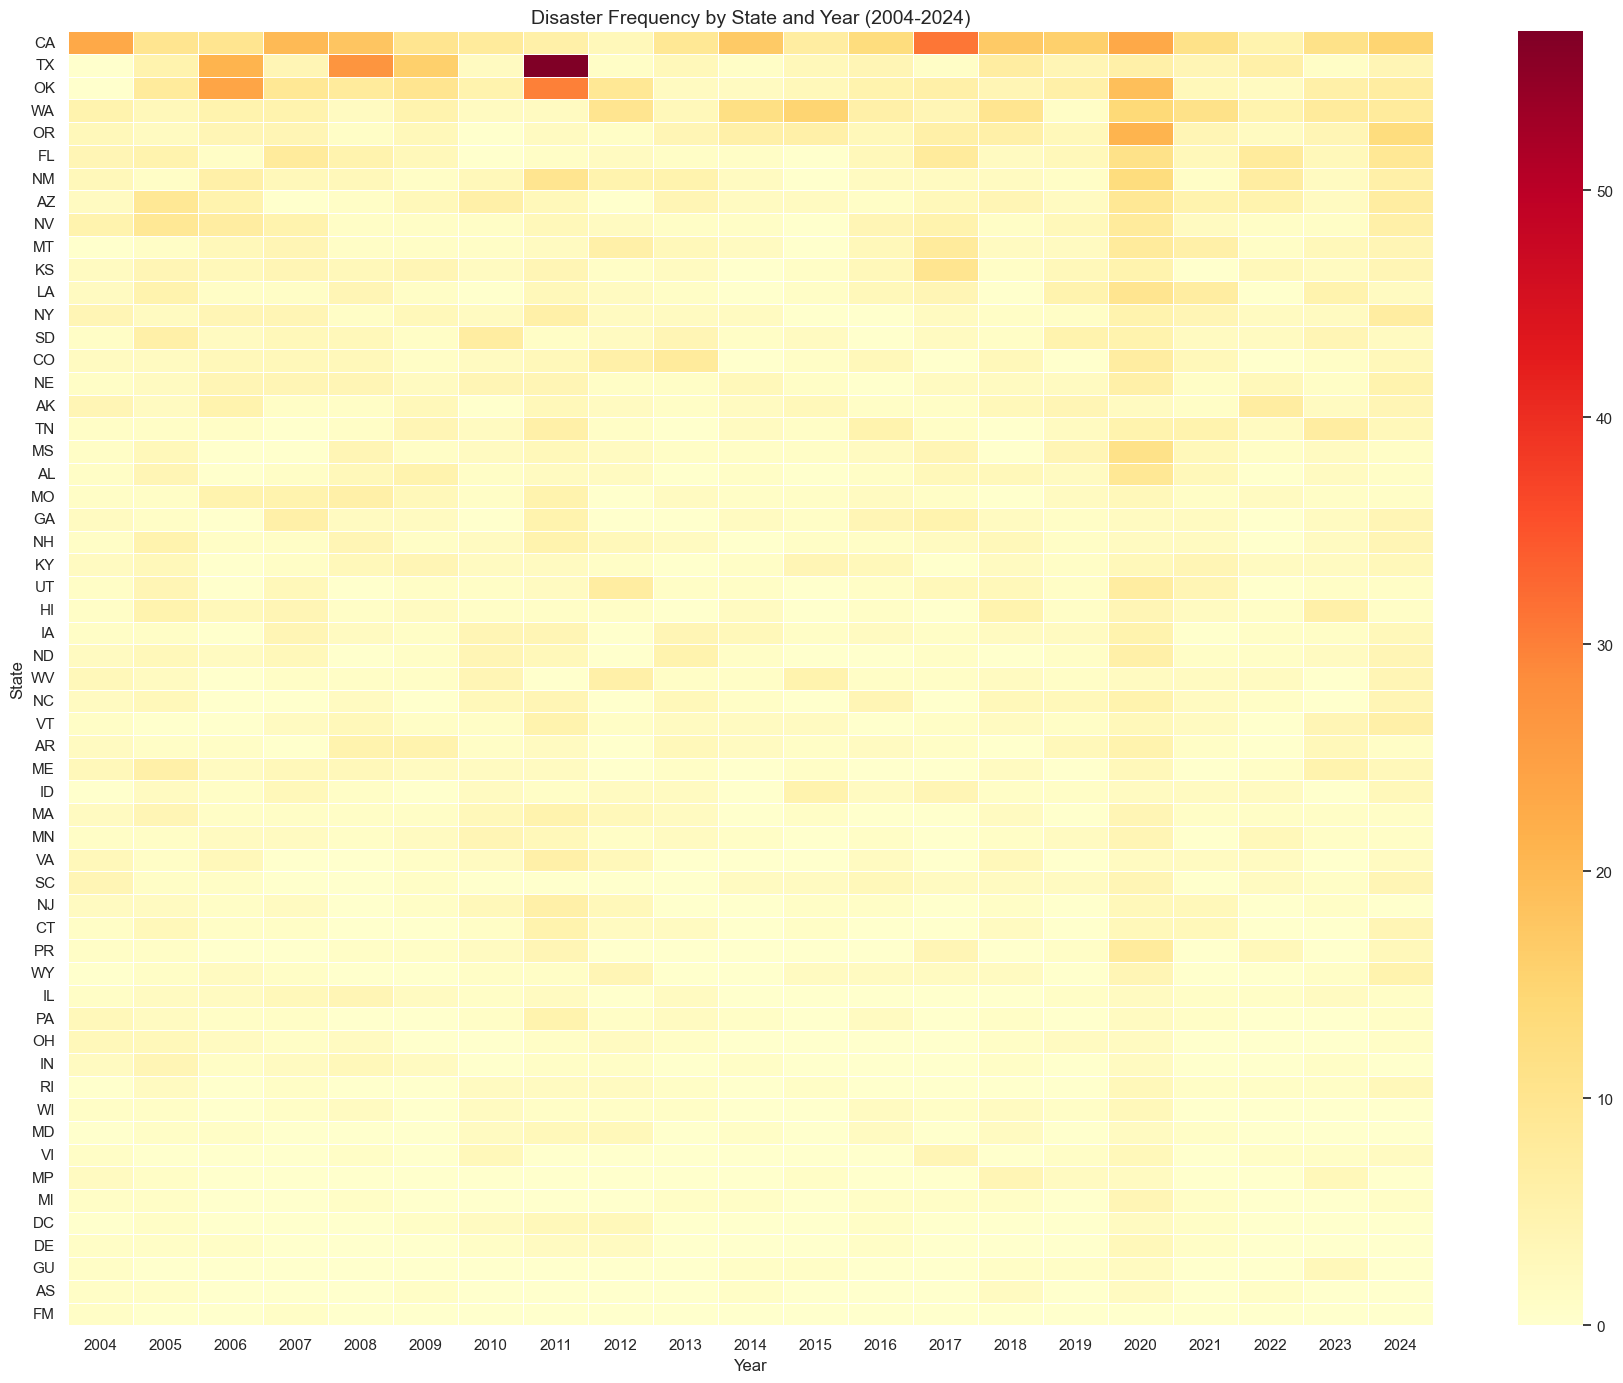

In [6]:
state_annual = (
    clean_df.groupby(["state", "declaration_year"])
    .agg(disaster_count=("disasterNumber", "nunique"))
    .reset_index()
)
pivot_state = state_annual.pivot(
    index="state", columns="declaration_year", values="disaster_count"
).fillna(0)

# Sort by total disaster count
pivot_state["total"] = pivot_state.sum(axis=1)
pivot_state = pivot_state.sort_values("total", ascending=False).drop(columns="total")

fig, ax = plt.subplots(figsize=(18, 14))
sns.heatmap(pivot_state, cmap="YlOrRd", annot=False, linewidths=0.5, ax=ax)
ax.set_title("Disaster Frequency by State and Year (2004-2024)", fontsize=14)
ax.set_xlabel("Year")
ax.set_ylabel("State")
plt.tight_layout()
plt.savefig(REPORTS_FIGURES / "state_year_heatmap.png", bbox_inches="tight")
plt.show()

## 6. Top 20 Most Disaster-Affected Counties

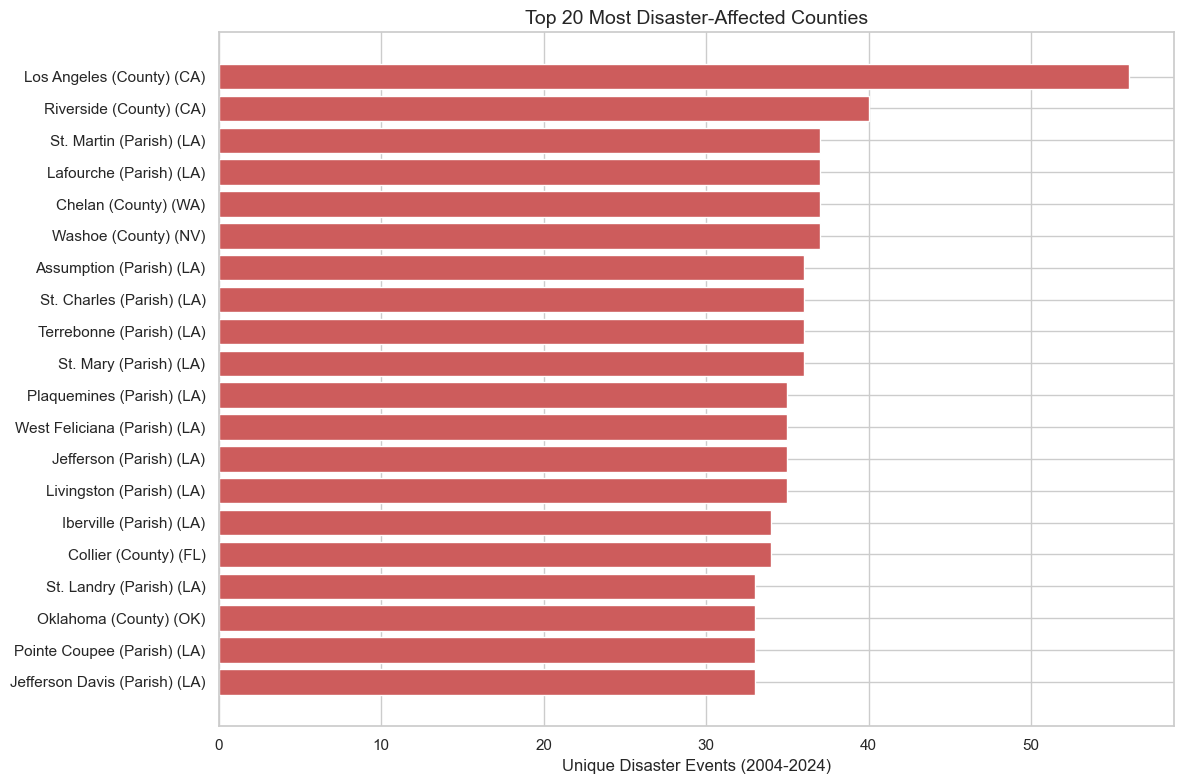

          designatedArea state  total_disasters
    Los Angeles (County)    CA               56
      Riverside (County)    CA               40
     St. Martin (Parish)    LA               37
      Lafourche (Parish)    LA               37
         Chelan (County)    WA               37
         Washoe (County)    NV               37
     Assumption (Parish)    LA               36
    St. Charles (Parish)    LA               36
     Terrebonne (Parish)    LA               36
       St. Mary (Parish)    LA               36
    Plaquemines (Parish)    LA               35
 West Feliciana (Parish)    LA               35
      Jefferson (Parish)    LA               35
     Livingston (Parish)    LA               35
      Iberville (Parish)    LA               34
        Collier (County)    FL               34
     St. Landry (Parish)    LA               33
       Oklahoma (County)    OK               33
  Pointe Coupee (Parish)    LA               33
Jefferson Davis (Parish)    LA          

In [7]:
county_totals = (
    clean_df[~clean_df["is_statewide"]]
    .groupby(["county_fips", "state", "designatedArea"])
    .agg(total_disasters=("disasterNumber", "nunique"))
    .reset_index()
    .sort_values("total_disasters", ascending=False)
    .head(20)
)

fig, ax = plt.subplots(figsize=(12, 8))
labels = county_totals["designatedArea"] + " (" + county_totals["state"] + ")"
ax.barh(labels, county_totals["total_disasters"], color="indianred")
ax.set_xlabel("Unique Disaster Events (2004-2024)")
ax.set_title("Top 20 Most Disaster-Affected Counties", fontsize=14)
ax.invert_yaxis()
plt.tight_layout()
plt.savefig(REPORTS_FIGURES / "top_counties.png", bbox_inches="tight")
plt.show()

print(county_totals[["designatedArea", "state", "total_disasters"]].to_string(index=False))

## 7. Geographic Distribution: County-Level Choropleth

In [8]:
county_map_data = (
    clean_df[~clean_df["is_statewide"]]
    .groupby("county_fips")
    .agg(total_disasters=("disasterNumber", "nunique"))
    .reset_index()
)

fig = px.choropleth(
    county_map_data,
    geojson="https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json",
    locations="county_fips",
    color="total_disasters",
    color_continuous_scale="YlOrRd",
    scope="usa",
    title="Disaster Frequency by County (2004-2024)",
    labels={"total_disasters": "Disasters"},
)
fig.update_layout(
    margin={"r": 0, "t": 40, "l": 0, "b": 0},
    width=1000,
    height=600,
)
fig.show()

## 8. Incident Duration Analysis

Incident Duration (days) by Disaster Type:
                     count   mean     50%     max
disaster_category                                
Other               8910.0  896.4  1207.0  1207.0
Drought                1.0  242.0   242.0   242.0
Volcanic               2.0  154.0   154.0   202.0
Earthquake           142.0   75.3    38.0   188.0
Wildfire            1978.0   71.1    28.0   377.0
Flood               3404.0   37.3    23.0   156.0
Severe Storm       11354.0   21.4    12.0   182.0
Coastal Storm        469.0   21.0    25.0    33.0
Hurricane          11554.0   19.8    14.0    67.0
Winter Storm        2255.0    8.8     9.0    37.0
Landslide             32.0    7.9     6.0    37.0
Tornado              229.0    5.3     2.0    15.0


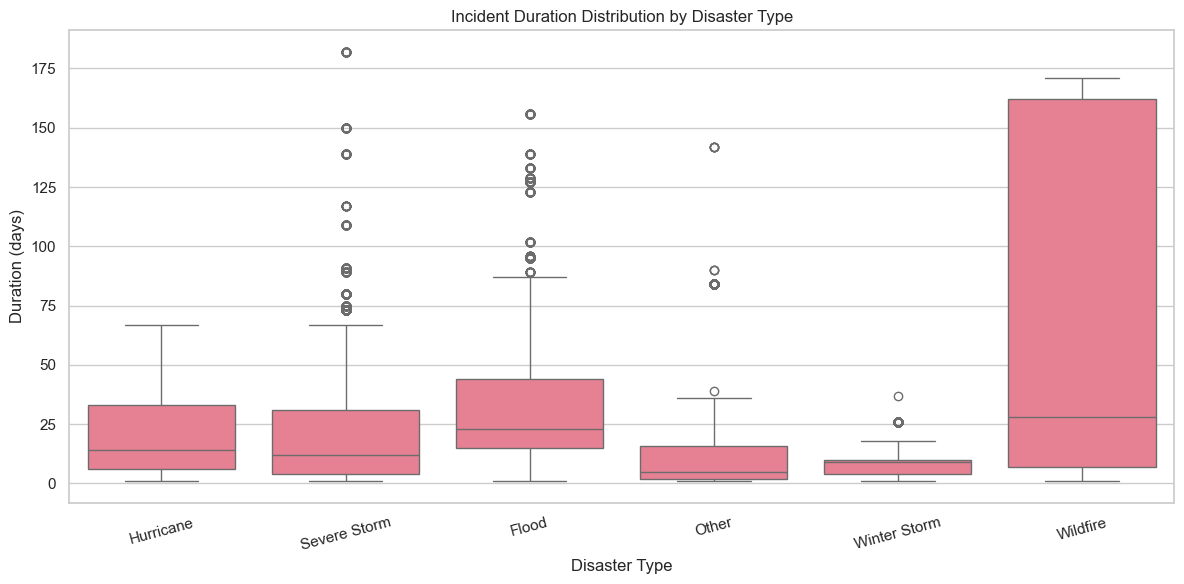

In [9]:
duration_by_type = (
    clean_df[clean_df["incident_duration_days"].notna() & (clean_df["incident_duration_days"] > 0)]
    .groupby("disaster_category")["incident_duration_days"]
    .describe()
    .round(1)
    .sort_values("mean", ascending=False)
)

print("Incident Duration (days) by Disaster Type:")
print(duration_by_type[["count", "mean", "50%", "max"]].to_string())

fig, ax = plt.subplots(figsize=(12, 6))
valid_duration = clean_df[
    clean_df["incident_duration_days"].notna()
    & (clean_df["incident_duration_days"] > 0)
    & (clean_df["incident_duration_days"] < 365)  # exclude extreme outliers
]
top_types = valid_duration["disaster_category"].value_counts().head(6).index
sns.boxplot(
    data=valid_duration[valid_duration["disaster_category"].isin(top_types)],
    x="disaster_category",
    y="incident_duration_days",
    ax=ax,
    order=top_types,
)
ax.set_title("Incident Duration Distribution by Disaster Type")
ax.set_xlabel("Disaster Type")
ax.set_ylabel("Duration (days)")
plt.xticks(rotation=15)
plt.tight_layout()
plt.savefig(REPORTS_FIGURES / "duration_by_type.png", bbox_inches="tight")
plt.show()

## 9. Key Findings Summary

**Observations to fill after running:**
- Overall trend direction (increasing/decreasing/stable)
- Dominant disaster types and their trends
- Peak months for each disaster category
- Geographic hotspots (states and counties)
- Notable outlier years (e.g., 2005 Katrina, 2017 Harvey/Irma/Maria, 2020 COVID+storms)
- Incident duration patterns by type

**Implications for Module 2 (Insurance Impact):**
- Which regions show accelerating disaster frequency?
- Which disaster types cause the longest disruptions?
- Are there emerging geographic patterns suggesting new risk zones?